# Combining Vector Spaces

In this guide you will learn how to run simulations with a large number of
spins by computing on a subspace given by a restricted set of states.
To demonstrate this approach, we consider the following spin system.
We split the sites into $n_1$ sites that experience a strong
interaction and $n_2$ sites that experience a weak interaction, while a
magnetic field is acting on all sites. More precisely, we consider the
Hamiltonian

$$
\hat{H}
  = - B \sum_j \hat{S}^z_j
  + J_\mathrm{strong}
    \sum_{j=0}^{n_1 - 2} \hat{\mathbf{S}}_j \hat{\mathbf{S}}_{j+1}
  + J_\mathrm{weak}
    \sum_{j < k} R_{jk} \, \hat{\mathbf{S}}_j \hat{\mathbf{S}}_k
  \,,
$$
where $B, J_\mathrm{strong}, J_\mathrm{weak} \in \mathbb{R}$ and
$R \in \mathbb{R}^{n \times n}$. Furthermore, we choose the entries
in the strictly upper triangle of $R$ to be uniformly randomly distributed
between $0$ and $1$ and the remaining entries to be zero.

The Hamiltonian is defined on the space $V = V_1 \otimes V_2$,
where $V_1$ contains all possible spin states on the first $n_1$ sites and
$V_2$ contains the states where at most one spin of the remaining sites is
in the $\uparrow$ state. While the number of states represented by $V_1$
grows exponentially with $n_1$, the number of states represented by
$V_2$ *only grows linearly* with $n_2$. Thus, we can perform computations
with large values for $n_2$.

## Imports and Parameters

Throughout this guide, we will make use of the following imports.

In [1]:
import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

from hqs_quantum_solver.spins import (
    VectorSpace, Operator, magnetic_field_z, isotropic_interaction, spin_z)

# License check turned off for lattice_functions.
# License check turned off for lattice_solver.


Furthermore, we use the following parameters.

In [2]:
sites_part1 = 12  # Number of sites of the first part
sites_part2 = 50  # Number of sites of the second part

B = -1.5      # The magnetic field strength
J_strong = 1  # The strength of the strong interaction
J_weak = 0.2  # The strength of the weak interaction

## Vector Spaces

We want to construct the Hamiltonian $\hat{H}$ of the system, which
requires to define the vector space that the operator is defined on,
first.

We start by defining the space $V_1$, which we do by constructing a
[VectorSpace](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.VectorSpace) object from the
[spins](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html) module. The vector space object is
defined by the states that it represents, which are in turn defined by
the number of spins in the system (`sites`) and the restriction on the
total spin polarization in $z$-direction (`total_spin_z`).
Since we do not want to restrict the total spin polarization, we just
pass `"all"` for this argument.

In [3]:
v1 = VectorSpace(sites=sites_part1, total_spin_z="all")

To create the space $V_2$, we need to combine two spaces. The first space just
represents the state where all spins are in the $\downarrow$ state, and the
second space represents the states where just one spin is in the $\uparrow$
state. The first one is characterized by a total spin polarization of
$- \frac{n_2 \hbar}{2}$ and the second one by a total spin polarization of
$- \frac{(n_2-2) \hbar}{2}$.
We want a vector space that represents the states represented by both
spaces combined. Using the `|`
(or the [span](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.VectorSpace.span) method)
the desired space is constructed from the individual spaces. Note that
the total spin is specified in units of $\tfrac{\hbar}{2}$.

In [4]:
v2 = (VectorSpace(sites=sites_part2, total_spin_z=-sites_part2)
      | VectorSpace(sites=sites_part2, total_spin_z=-sites_part2 + 2))

Finally, we can use the `*` operator to compute the desired tensor product
$V = V_1 \otimes V_2$.

In [5]:
v = v1 * v2

The next step is to define the coefficient matrices.

## Building Operators

Building an operator in Quantum Solver works by calling the constructor
of the desired [Operator](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.Operator) class with an
expression describing the operator and the vector space.

The expression describing the magnetic field can be obtained by using
the [magnetic_field_z](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.magnetic_field_z) function.
By providing the `coef` argument, we can specify the magnetic field in
$z$-direction per site as a vector. This vector is constructed by the
code below.

In [6]:
B_coef = np.full(v.sites, B)

To define the interaction part of the Hamiltonian, we want to use the
[isotropic_interaction](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.isotropic_interaction)
function, which gives the desired expression when given an appropriate
coefficient matrix. Looking at the documentation of the function shows that
we can describe the term
$$
  J_{\mathrm{strong}}
  \sum_{j=0}^{n_1 - 2} \hat{\mathbf{S}}_j \hat{\mathbf{S}}_{j+1}
$$
by providing a matrix where the first $(n_1-2)$ entries of the first upper
off-diagonal are set to $J_{\mathrm{strong}}$ and the remaining entries
set to zero. This matrix is constructed as follows.

In [7]:
d1 = np.where(np.arange(v.sites - 1) < v1.sites - 1, 1, 0)
J_strong_mat = J_strong * np.diag(d1, 1)

The second term is represented by a coefficient matrix with random
coefficients in $[0, J_\mathrm{weak}]$.

In [8]:
rng = np.random.default_rng(314159)

J_weak_mat = J_weak * np.triu(rng.uniform(0, 1, (v.sites, v.sites)), 1)

Now, that we have the coefficient matrices, we can build the Hamiltonian.
The interaction term, however, maps onto states that are not part of
the vector space $V$. Oftentimes, this is an indicator for an error. Hence, we
have to pass `strict=False` as an argument to the Operator constructor, to
explicitly allow Quantum Solver to drop states not present in the vector
space.

In [9]:
H = Operator(
    magnetic_field_z(coef=B_coef) + isotropic_interaction(J_strong_mat + J_weak_mat),
    domain=v,
    strict=False
)

## Spectrum & Eigenvectors

Having constructed the Hamiltonian, we can now use it to, e.g., compute
the energy levels of the system. Since Quantum Solver operators are
compatible with SciPy, we can directly use the
[eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html#scipy.sparse.linalg.eigsh) function from SciPy to compute the
eigenvalues.

In [10]:
eigvals, eigvecs = eigsh(H, k=20, which='SA')

The eigenvalues are the energy levels of the system and can be plotted
as follows, while the resulting figure is shown below.

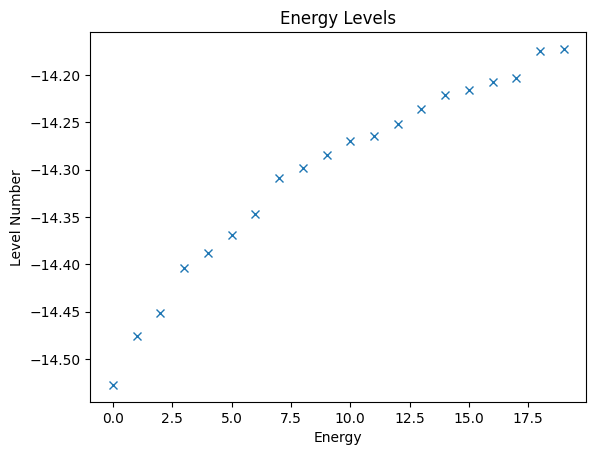

In [11]:
plt.figure()
plt.title('Energy Levels')
plt.xlabel('Energy')
plt.ylabel('Level Number')
plt.plot(eigvals, 'x')

Another interesting quantity to look at is the expectation value of the
spin polarization of the groundstate, i.e.,
$\langle S^z_j \rangle = \langle \psi | S^z_j | \psi \rangle$
for $j = 0, \dots, n_1 + n_2 - 1$.
The operator $S^z_j$ is provided by the
[spin_z](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.spin_z) function,
and the application of the operator by the
[dot](https://docs.cloud.quantumsimulations.de/hqs-quantum-solvers/reference/generated/hqs_quantum_solver.spins.html#hqs_quantum_solver.spins.Operator.dot) method,
so the implementation is straight forward.

In [12]:
observables = [Operator(spin_z(site=j), domain=v) for j in range(v.sites)]

def spin_z_expectation(psi):
    return [np.vecdot(psi, o.dot(psi)) for o in observables]

The result can be plotted using the following code, and the resulting
figure is shown below.

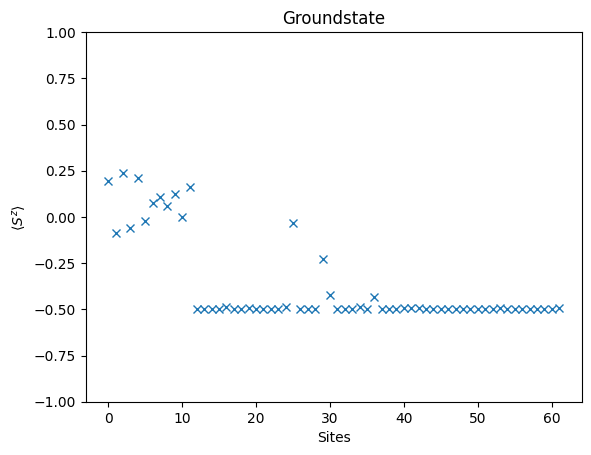

In [13]:
groundstate = eigvecs[:,0]

plt.figure()
plt.title('Groundstate')
plt.xlabel('Sites')
plt.ylabel(r'$\langle S^z \rangle$')
plt.ylim(-1, 1)
plt.plot(spin_z_expectation(groundstate), 'x')

plt.show()

## Complete Code

```python
# Title    : HQS Quantum Solver Combining Vector Spaces
# Filename : combining-spaces.py

# ===== Imports =====

import numpy as np
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

from hqs_quantum_solver.spins import (
    VectorSpace, Operator, magnetic_field_z, isotropic_interaction, spin_z)

# ===== Parameters =====

sites_part1 = 12  # Number of sites of the first part
sites_part2 = 50  # Number of sites of the second part

B = -1.5      # The magnetic field strength
J_strong = 1  # The strength of the strong interaction
J_weak = 0.2  # The strength of the weak interaction

# ===== Vector Spaces =====

v1 = VectorSpace(sites=sites_part1, total_spin_z="all")

v2 = (VectorSpace(sites=sites_part2, total_spin_z=-sites_part2)
      | VectorSpace(sites=sites_part2, total_spin_z=-sites_part2 + 2))

v = v1 * v2

# ===== Building the Hamiltonian =====

B_coef = np.full(v.sites, B)

d1 = np.where(np.arange(v.sites - 1) < v1.sites - 1, 1, 0)
J_strong_mat = J_strong * np.diag(d1, 1)

rng = np.random.default_rng(314159)

J_weak_mat = J_weak * np.triu(rng.uniform(0, 1, (v.sites, v.sites)), 1)

H = Operator(
    magnetic_field_z(coef=B_coef) + isotropic_interaction(J_strong_mat + J_weak_mat),
    domain=v,
    strict=False
)

# ===== Plotting the Energy Levels =====

eigvals, eigvecs = eigsh(H, k=20, which='SA')

plt.figure()
plt.title('Energy Levels')
plt.xlabel('Energy')
plt.ylabel('Level Number')
plt.plot(eigvals, 'x')

# ===== Plotting the Spin Polarization =====

observables = [Operator(spin_z(site=j), domain=v) for j in range(v.sites)]

def spin_z_expectation(psi):
    return [np.vecdot(psi, o.dot(psi)) for o in observables]

groundstate = eigvecs[:,0]

plt.figure()
plt.title('Groundstate')
plt.xlabel('Sites')
plt.ylabel(r'$\langle S^z \rangle$')
plt.ylim(-1, 1)
plt.plot(spin_z_expectation(groundstate), 'x')

plt.show()

```